# EX3: GW150914
In this example we load an LVK posterior from zenodo and compute the FI evidence for the CBC model.

Download posteriors from [zenodo](https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5?download=1)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import h5py
import numpy as np
import pandas as pd
from collections import namedtuple
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list
import shutil, os

np.random.seed(42)

## Load GW150914 posterior + Nested Sampling LnZ

In [4]:
! pip install loguru

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/eugeny/tabby/pypi/simple
  Using cached loguru-0.7.0-py3-none-any.whl (59 kB)


In [6]:
# load the LVK posterior
FPATH = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'

LVK_data = namedtuple("LVK_data", "posterior, lnz, lnz_err, lnBF")


def load_lvk_data(fpath):
    with h5py.File(fpath, 'r') as f:
        sampling_params = list(f['C01:IMRPhenomXPHM/priors/analytic'].keys())
        # remove mass_1, mass_2 (as we already have chirp_mass, mass_ratio)
        sampling_params = [p for p in sampling_params if p not in ['mass_1', 'mass_2', 'time_jitter']]
        sampler_data = f['C01:IMRPhenomXPHM/meta_data/sampler']
        lnz, lnz_err =  sampler_data['ln_evidence'][0], sampler_data['ln_evidence_error'][0]
        lnBF = sampler_data['ln_bayes_factor'][0]
        post = f['C01:IMRPhenomXPHM']['posterior_samples'][()]
        post = pd.DataFrame({name: post[name][:] for name in post.dtype.names})
        post = post[sampling_params + ['log_likelihood', 'log_prior']]
        # only keep parameters with more than one unique value (ie drop deltas)
        post = post.loc[:, post.nunique() > 1]
    return LVK_data(post, lnz, lnz_err, lnBF)


GW150914_data = load_lvk_data(FPATH)

In [7]:

# GW150914_data.posterior.columns WITHOUT log_likelihood and log_prior
sampling_params = set(list(GW150914_data.posterior.columns))-set(['log_likelihood', 'log_prior'])
print("CBC PARAMS:")
count = 0
for i in sorted(sampling_params):
    if 'calib' not in i:
        count += 1
        print(count, ")", i)
print("CALIB PARAMS:")
calib_params = []
count = 0
for i in sorted(sampling_params):
    if 'calib' in i:
        count += 1
        print(count, ")", i)
        calib_params.append(i)


CBC PARAMS:
1 ) a_1
2 ) a_2
3 ) azimuth
4 ) chirp_mass
5 ) geocent_time
6 ) luminosity_distance
7 ) mass_ratio
8 ) phase
9 ) phi_12
10 ) phi_jl
11 ) psi
12 ) theta_jn
13 ) tilt_1
14 ) tilt_2
15 ) zenith
CALIB PARAMS:
1 ) recalib_H1_amplitude_0
2 ) recalib_H1_amplitude_1
3 ) recalib_H1_amplitude_2
4 ) recalib_H1_amplitude_3
5 ) recalib_H1_amplitude_4
6 ) recalib_H1_amplitude_5
7 ) recalib_H1_amplitude_6
8 ) recalib_H1_amplitude_7
9 ) recalib_H1_amplitude_8
10 ) recalib_H1_amplitude_9
11 ) recalib_H1_phase_0
12 ) recalib_H1_phase_1
13 ) recalib_H1_phase_2
14 ) recalib_H1_phase_3
15 ) recalib_H1_phase_4
16 ) recalib_H1_phase_5
17 ) recalib_H1_phase_6
18 ) recalib_H1_phase_7
19 ) recalib_H1_phase_8
20 ) recalib_H1_phase_9
21 ) recalib_L1_amplitude_0
22 ) recalib_L1_amplitude_1
23 ) recalib_L1_amplitude_2
24 ) recalib_L1_amplitude_3
25 ) recalib_L1_amplitude_4
26 ) recalib_L1_amplitude_5
27 ) recalib_L1_amplitude_6
28 ) recalib_L1_amplitude_7
29 ) recalib_L1_amplitude_8
30 ) recalib_L1_ampl

In [20]:
data = h5py.File(FPATH, 'r')
for k,v in data['C01:IMRPhenomXPHM/priors/analytic'].items():
    print(k,v[()])
data.close()

a_1 [b"Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None)"]
a_2 [b"Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None)"]
azimuth [b"Uniform(minimum=0, maximum=6.283185307179586, name=None, latex_label='$\\\\epsilon$', unit=None, boundary='periodic')"]
chirp_mass [b"UniformInComponentsChirpMass(minimum=21.418182160215295, maximum=41.97447913941358, name='chirp_mass', latex_label='$\\\\mathcal{M}$', unit='$M_{\\\\odot}$', boundary=None)"]
geocent_time [b"Uniform(minimum=1126259462.2910001, maximum=1126259462.491, name='geocent_time', latex_label='$t_c$', unit='$s$', boundary=None)"]
luminosity_distance [b"PowerLaw(alpha=2, minimum=10, maximum=10000, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None)"]
mass_1 [b"Constraint(minimum=1, maximum=1000, name='mass_1', latex_label='$m_1$', unit=None)"]
mass_2 [b"Constraint(minimum=1, maximum=1000, name='mass_2', latex_label='$m_2$', unit=Non

In [8]:
print(f"Posterior shape: {GW150914_data.posterior.shape}")
print(f"LnZ: {GW150914_data.lnz:.2f} +/- {GW150914_data.lnz_err:.2f}")
print(f"LnBF: {GW150914_data.lnBF}")
GW150914_data.posterior.head().T

Posterior shape: (147634, 57)
LnZ: -6984.67 +/- 0.14
LnBF: 303.45


,0,1,2,3,4
a_1,9.242101e-01,6.473688e-01,2.056780e-01,7.112512e-01,2.506404e-01
a_2,3.310924e-01,3.133050e-01,8.750084e-01,4.800071e-03,2.271518e-01
azimuth,3.278707e+00,2.602855e+00,2.715020e+00,2.380721e+00,2.783846e+00
chirp_mass,2.918072e+01,2.995305e+01,3.143389e+01,3.074103e+01,3.127060e+01
geocent_time,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09,1.126259e+09
luminosity_distance,3.237332e+02,5.109554e+02,5.009286e+02,5.780114e+02,5.871190e+02
mass_ratio,7.879585e-01,8.641748e-01,8.520294e-01,9.803410e-01,9.301303e-01
phase,3.840744e+00,4.337254e+00,1.757881e+00,4.723087e+00,5.542601e+00
phi_12,5.394340e+00,3.868170e+00,2.916934e+00,4.591901e+00,6.435515e-01
phi_jl,1.210051e+00,2.486261e-02,5.576937e+00,9.338661e-01,6.019726e+00


NOTE: the `log-likelihood` column is actually the `lnl-noise Lnl` (the `log-likelihood-ratio`).

## Compute FI LnZ

### Using a downsampled posterior sample for speed

In [10]:
OUTDIR = 'out_GW150914_downsampled'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

# USING DOWNSAMPLED POSTERIOR SAMPLES
N_SAMP = 10000
N_REF_POINTS = 100
post = GW150914_data.posterior.sample(N_SAMP, weights=np.exp(GW150914_data.posterior.log_likelihood))
print(f"Using {100*(len(post)/len(GW150914_data.posterior)):.2f}% of posterior samples, and trying out {N_REF_POINTS} reference points.")
lnzs, r_vals, _ = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.geomspace(1e2, 1e5, 10),
    cache_fn=f'{OUTDIR}/lnzs.npz',
    weight_samples_by_lnl=True,
)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (10000, 55) 


Using 6.77% of posterior samples, and trying out 100 reference points.


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

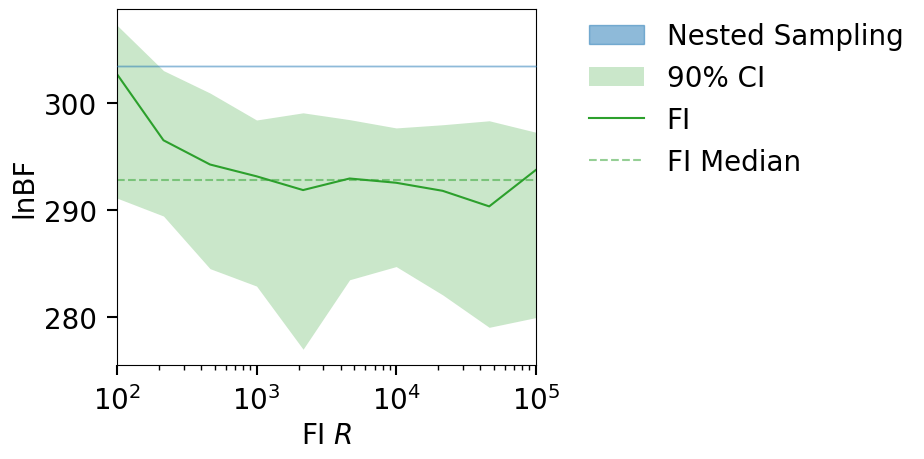

In [11]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[GW150914_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.gca().set_ylabel("lnBF");

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (10000, 15) 


Using 6.77% of posterior samples, and trying out 100 reference points.


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

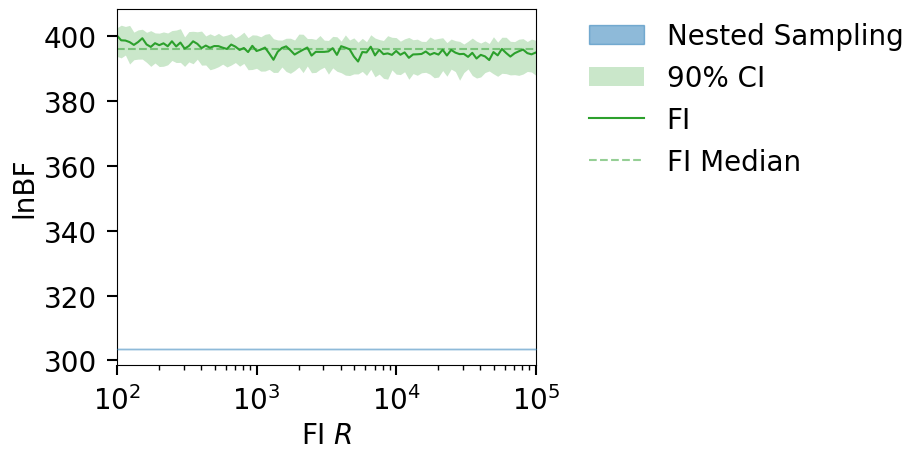

In [18]:
OUTDIR = 'out_GW150914_downsampled_no_calib'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)





# USING DOWNSAMPLED POSTERIOR SAMPLES
N_SAMP = 10000
N_REF_POINTS = 10
post = GW150914_data.posterior.sample(N_SAMP, weights=np.exp(GW150914_data.posterior.log_likelihood))
print(f"Using {100*(len(post)/len(GW150914_data.posterior)):.2f}% of posterior samples, and trying out {N_REF_POINTS} reference points.")

# post = post.drop(columns=calib_params)

lnzs, r_vals, _ = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.geomspace(1e2, 1e5, 10),
    cache_fn=f'{OUTDIR}/lnzs.npz',
    weight_samples_by_lnl=True,
)

plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[GW150914_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=False, plt_kwgs=dict(alpha=.1))
fig.gca().set_ylabel("lnBF");

### Using the full posterior sample but a few refernce points

In [58]:
OUTDIR = 'out_GW150914'
CLEAN = True
if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

N_REF_POINTS = 10
post = GW150914_data.posterior
lnzs, r_vals, _ = get_fi_lnz_list(
    post,
    num_ref_params=N_REF_POINTS,
    r_vals=np.geomspace(50, 1e5, 100),
    cache_fn=f'{OUTDIR}/lnzs.npz',
)

|funnel|INFO| Calculating FI LnZ with 10 reference points and a posterior of size: (147634, 55) 


FI LnZ:   0%|          | 0/10 [00:00<?, ?it/s, FI LnZ: 0]

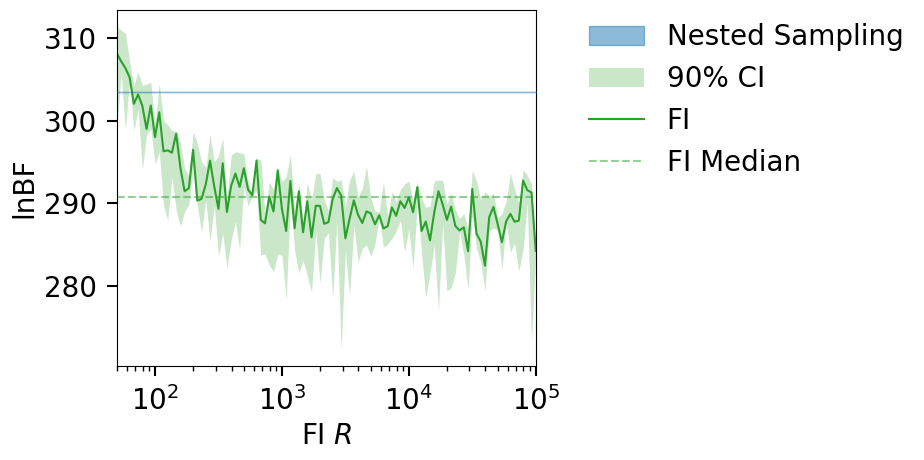

In [59]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals,sampling_lnz=[GW150914_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.gca().set_ylabel("lnBF");

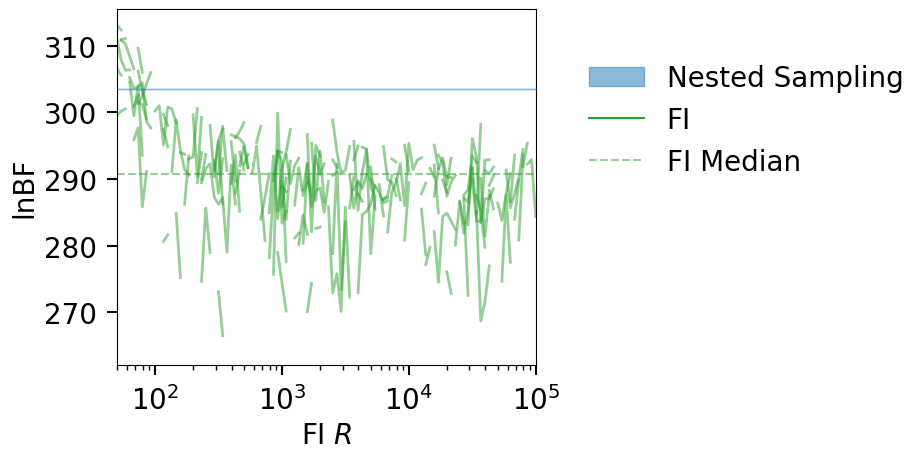

In [60]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=0.5, lw=2))
fig.gca().set_ylabel("lnBF");